In [7]:
from IPython.display import display, HTML # import from core is deprecated
css_file = './custom.css'
HTML(open(css_file, "r").read())

###### Content provided under a Creative Commons Attribution license, CC-BY 4.0; code under MIT License. (c)2014 [David I. Ketcheson](http://davidketcheson.info)

##### version 0.1 - May 2014

# Hyperbolic Conservation Laws

$
\newcommand{\Dx}{\Delta x}
\newcommand{\Dt}{\Delta t}
\newcommand{\imh}{{i-1/2}}
\newcommand{\iph}{{i+1/2}}
$
Many models of wave phenomena are governed by *hyperbolic conservation laws*.  In this short course, we will learn about hyperbolic conservation laws and their numerical solution.

## Conservation of mass

Imagine a fluid flowing in a narrow tube.  We'll use $q$ to indicate the density of the fluid and $u$ to indicate its velocity.  Both of these are functions of space and time: $q = q(x,t)$; $u=u(x,t)$.  The total mass in the section of tube $[x_1,x_2]$ is

\begin{equation}
\int_{x_1}^{x_2} q(x,t) dx.
\end{equation}

This total mass can change in time due to fluid flowing in or out of this section of the tube.  We call the rate of flow the *flux*, and represent it with the function $f(q)$.  Thus the net rate of flow of mass into (or out of) the interval $[x_1,x_2]$ at time $t$ is

$$f(q(x_1,t)) - f(q(x_2,t)).$$

We just said that this rate of flow must equal the time rate of change of total mass; i.e.

$$\frac{d}{dt} \int_{x_1}^{x_2} q(x,t) dx = f(q(x_1,t)) - f(q(x_2,t)).$$

Now since $\int_{x_1}^{x_2} \frac{\partial}{\partial x} f(q) dx = f(q(x_2,t)) - f(q(x_1,t))$, we can rewrite this as

$$\frac{d}{dt} \int_{x_1}^{x_2} q(x,t) dx = -\int_{x_1}^{x_2} \frac{\partial}{\partial x} f(q) dx.$$

Under certain smoothness assumptions on $q$, we can move the time derivative inside the integral.  We'll also put everything on the left side, to obtain

$$\int_{x_1}^{x_2} \left(\frac{\partial}{\partial t}q(x,t) + \frac{\partial}{\partial x} f(q)\right) dx = 0.$$

Since this integral is zero for *any* choice of $x_1,x_2$, it must be that the integrand (the expression in parentheses) is actually zero *everywhere*!  Therefore we can write the **differential conservation law**

$$q_t + f_x = 0.$$

Here and throughout the course, we use subscripts to denote partial derivatives.
This equation expresses the fact that the total mass is conserved -- since locally the mass can change only due to a net inflow or outflow.

## Advection

In order to solve the conservation law above, we need an expression for the flux, $f$.  The rate of flow is just mass times velocity: $f=u q$.  Thus we obtain the **continuity equation**

$$q_t + (uq)_x = 0.$$

In general, we need another equation to determine the velocity $u(x,t)$.  In [Lesson 4](Lesson_04_Fluid_dynamics.ipynb) we'll look at the full equations of fluid dynamics, but for now let's consider the simplest case, in which all of the fluid flows at a single, constant velocity $u(x,t)=a$.  Then the continuity equation becomes the **advection equation**

$$q_t + a q_x = 0.$$

This equation has a very simple solution.  If we are given the density $q(x,0)=q_0(x)$ at time zero, then the solution is just

$$q(x,t) = q_0(x-at).$$

Let's plot the solution of the advection equation on the interval $[0,1]$ for the initial condition
$$q_0(x) = e^{-2(x-1/2)^2}.$$

First, let's import all the modules we'll need.

In [8]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib widget  
# use widget to support the VS Code jupyter animation viewer
# use notebook if you view the notebooks on the web environment

Next, we'll set up a grid and the initial condition:

In [9]:
x = np.linspace(0,1,1000)  # Spatial grid
t = np.linspace(0,1.4)       # Temporal grid
a = 1.0                    # Advection speed

def q_0(x):                # Initial condition
    return np.exp(-200.*(x+0.2)**2)

Finally, let's make an animation of the solution.  It will take a few moments to run this code.  For now, you don't need to worry about understanding all of the plotting code below.  Just play with the animation until you have a feel for how the solution behaves.

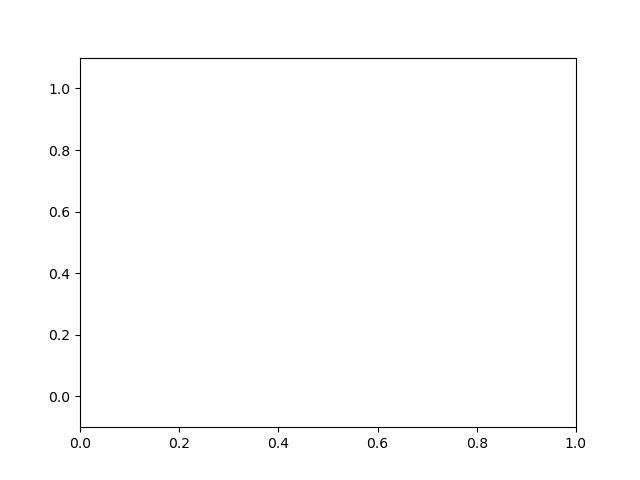

In [10]:
fig,ax = plt.subplots()
line, = ax.plot([], [],linewidth=2)  # Create an empty line plot
ax.set_xlim((0,1))             # Set the bounds of the plot
ax.set_ylim((-0.1,1.1))

def plot_q(t):
    line.set_data(x,q_0(x-a*t))  # Replace the line plot with the solution at time t
    
animation.FuncAnimation(fig, plot_q, frames=t)  # Animate the solution

As you can see, the initial pulse just moves to the right at speed $a$ as time advances.  This isn't very interesting, but it captures the most important feature of hyperbolic equations: waves travel at finite speed.

## Characteristics

Notice that the solution value is constant along the line $x-at=x_0$, in the $x-t$ plane, for each value of $x_0$.  These lines are called **characteristics**; they are the trajectories along which solution information is transmitted.  The value $a$ is referred to as the **characteristic velocity**.  The code below plots some of these characteristics.

When we learn about more complicated conservation laws, we'll see that information still travels along characteristics, but those characteristics aren't necessarily straight lines.

(0.0, 1.0)

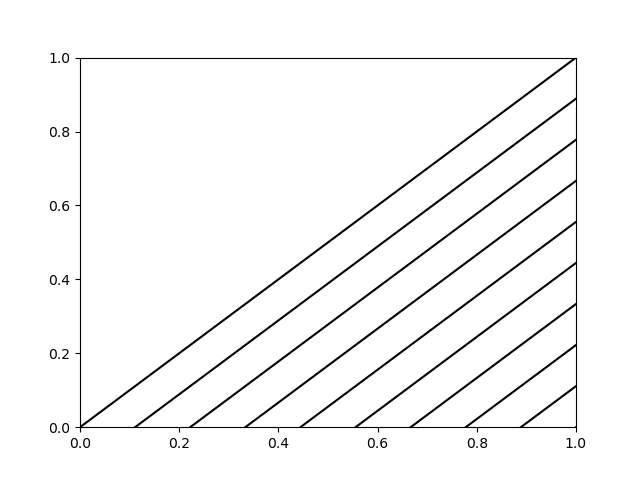

In [11]:

fig,ax = plt.subplots()

for x_0 in np.linspace(0,1,10):
    ax.plot(x,(x-x_0)/a,'-k')
ax.set_xlim((0,1))             # Set the bounds of the plot
ax.set_ylim((0,1))
plt.ylim(0,1)

## A finite volume method for advection

We can easily solve the advection equation exactly.  But the advection equation is a prototype for more complicated conservation laws that we will only be able to solve approximately by using numerical methods.  In order to better understand these methods, we will discuss them first in the context of the advection equation.

For simplicity, we'll suppose that we wish to solve the advection equation on the interval $[0,1]$.  We introduce a set of equally spaced *grid cells* of width $\Dx$, and write $x_i$ to mean the center of cell $i$.  Thus the first cell is the interval $[0,\Dx]$ and $x_1=\Dx/2$.  We will also write $x_\imh$ or $x_\iph$ to denote the left or right boundary of cell $i$, respectively.

We write $Q_i$ to denote the *average* value of the solution over cell $i$:

$$Q_i = \frac{1}{\Dx} \int_{x_\imh}^{x_\iph} q \ dx.$$

The simplest finite volume method is obtained by supposing that the solution is actually *equal* to $Q_i$ over all of cell $i$.

![](./figures/finite_volume.png)

Suppose $a>0$.  Then the flux into cell $i$ from the left is $a Q_{i-1}$ and the flux out of cell $i$ to the right is $a Q_i$.  Then our integral conservation law reads

$$Q_i'(t) = -\frac{a}{\Dx}\left(Q_i - Q_{i-1}\right).$$

Applying a forward difference in time we obtain the *upwind method*

$$Q^{n+1}_i = Q^n_i -\frac{a\Dt}{\Dx}\left(Q_i - Q_{i-1}\right).$$

We call this the upwind method because the solution behaves as if it were being blown by a wind to the right, and the method uses the value $Q_{i-1}$ from the upwind direction.

Here is a bit of Python code to solve the advection equation using the upwind method.

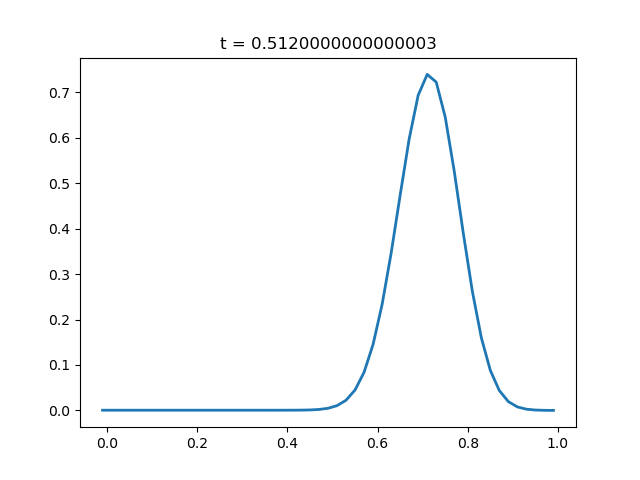

In [12]:
a = 1.0     # advection speed

m = 50      # number of cells
dx = 1./m   # Size of 1 grid cell
x = np.arange(-dx/2, 1.+dx/2, dx)  # Cell centers, including ghost cells

t = 0.      # Initial time
T = 0.5     # Final time
dt = 0.8 * dx / a  # Time step

Q = np.exp(-200*(x-0.2)**2)    # Initial data
Qnew = np.empty(Q.shape)

while t < T:
    
    # Extrapolation at boundaries:
    Qnew[0] = Q[1]
    Qnew[-1] = Q[-2]
    
    for i in range(1,len(x)):
        Qnew[i] = Q[i] - a*dt/dx * (Q[i]-Q[i-1])
    
    Q = Qnew.copy()
    t = t + dt
    
fig,ax = plt.subplots()
ax.plot(x,Q,linewidth = 2)
ax.set_title('t = '+str(t));

Notice how we set up a grid that contains an extra cell at each end, outside of the problem domain $[0,1]$.  These are called **ghost cells** and are often useful in handling the solution at the grid boundaries.

![](./figures/ghost-cell.png)

  The technique we have used to set the ghost cell values above, by copying the last value inside the grid to the ghost cells, is known as **zero-order extrapolation**.  It is useful for allowing waves to pass out of the domain (so-called *non-reflecting* boundaries).  Note that we don't actually need the ghost cell at the right end for the upwind method, but for other methods we will.

The upwind method is simple, but it is not very accurate.  Notice how the computed solution becomes wider and shorter over time.  This behavior is referred to as *dissipation*.

### Exercise

Now do the following with the code above:

1. Set $m=1000$ or more and notice that it takes some time to compute the solution.  Rewrite the inner loop (over $i$) as a single line with no loop, using numpy slicing.  For large values of $m$, the code with slicing is much faster.
1. Notice that the last step of the simulation goes past time $T$.  Modify the code so that the last step is adjusted to exactly reach $T$.
2. Change the code so that animation of the solution versus time is plotted.  You will want to accumulate frames of the solution in a list and then use the same kind of code we used above to animate the exact solution.
3. Add some code to plot the exact solution.

*Extra credit*: change the left boundary condition so that there is a sinusoidal wave coming in from the left:
$$u(0,t) = \sin(20 \pi t).$$
What do you notice about the sinusoid as it moves into the domain?

After making it through the exercise above, you should feel pretty comfortable with the basics of scientific programming in Python.

## The CFL condition

Take a look at the line of code that sets the time step:
```python
    dt = 0.8 * dx / a 
```
You might be wondering where that formula came from.  Rearranging that equation, we have
$$a \frac{\Delta t}{\Delta x} = 0.8.$$
The quantity $\nu = a \frac{\Delta t}{\Delta x}$ is the distance the exact solution moves during each time step, in units of grid cells.  It is referred to as the *CFL number* or just the *Courant number* after the authors Courant, Friedrichs and Lewy who [established its importance](http://www.stat.uchicago.edu/~lekheng/courses/302/classics/courant-friedrichs-lewy.pdf).  Try the following values of $\nu$ in the code above, and compare the results with those you obtained already using $\nu=0.8$.
1. $\nu = 1.0$
2. $\nu = 1.5$
3. $\nu = 0.1$

Finally, try setting $a$ to a negative value.  What happens?

The results you have observed can be explained as follows.  Over a time step of size $\Dt$, the solution moves by an amount $a \Dt$.  So $q(x_i,t_n)$ should be given exactly by $q(x_i-a\Dt,t_{n-1})$.  This is referred to as the *domain of dependence* of the solution.

The upwind method uses the values $Q_i^{n-1}$ and $Q_{i-1}^{n-1}$ to compute $Q_i^n$.  The points $(x_{i-1},t_n)$ and $(x_i,t_n)$ (as well as the locations of solution values they depend, and the ones those depend on, and so forth) are the *numerical domain of dependence*.

For this to work, the true domain of dependence $x_i-a\Dt$ must lie within the numerical domain of dependence, as $\Dt,\Dx \to 0$.  This is known as the [CFL condition](http://en.wikipedia.org/wiki/Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition).

For the upwind method, that means that we must have
$$x_i - \Dx \le x_i - a \Dt \le x_i$$
or in other words
$$0 \le a \frac{\Dt}{\Dx} \le 1.$$

If the CFL condition is violated, the information that is used by the numerical method doesn't include the true information that influences the exact solution, so the numerical solution cannot be convergent.

## The Lax-Friedrichs method

The upwind method gets its name from the fact that it uses the value $U_{i-1}$ and not $U_{i+1}$.  Assuming $a>0$, the correct solution value $U_i^{n+1}$ should come from a point to the left of $x_i$ at time $t_n$ (i.e., the wind blows to the right, so $x_{i-1}$ is *upwind* of $x_i$).

This bias is fine for the advection equation, where we know everything moves in the same direction.  But for more complicated conservation laws, things may move in either direction.  It will be useful to have a method that uses information from both directions.  The simplest such method is known as the **Lax-Friedrichs** method.  For the conservation law $q_t + f(q)_x$, this method is

$$Q_i^{n+1} = \frac{1}{2}(Q_{i-1}^n + Q_{i+1}^n) - \frac{\Dt}{2\Dx}\left(f(Q_{i+1}^n) - f(Q_{i-1}^n)\right).$$

Notice that the flux difference term clearly approximates $f(q)_x$.  Meanwhile, the value of $q$ itself is approximated by taking the average of two neighboring values.  This average makes this method dissipative too (but it ensures that the solution is stable).

### Exercise

1. What does the CFL condition imply for the time step when using the Lax-Friedrichs method?

2. In the cell below, implement the Lax-Friedrichs method for advection.

*Extra credit*: Compute the norm of the difference between the approximate and exact solution.  How does it change if you decrease $\Dx$?

## Accuracy

The methods we have used so far (i.e., the *upwind method* and the *Lax-Friedrichs method*) are both dissipative.  Furthermore, both of these methods are only *first order accurate*, meaning that if we reduce the values of $\Dt$ and $\Dx$ by a factor of two, the overall error decreases only by a factor of two.  In [Lesson 3](Lesson_03_High-resolution_methods.ipynb), we will learn about more accurate methods.  But first, in [Lesson 2](Lesson_02_Traffic.ipynb) we'll look at a model for traffic flow.